# Graph Embedding in Siegel Space

## Problem: Are Siegel spaces better suited for graph embedding problems than hyperbolic space?

The primary objective of graph embedding is to find a geometric realization of a given graph so that the ambient geometry of the space reveals structural properties about the graph. Euclidean space is the most popular choice for embedding because it is easiest to visualize. However, many graphs have non-Euclidean structure. The hyperbolic plane is also a popular choice of target space for embedding because the constant negative curvature allow one to control the distortion of distance between nodes.

In 2021, the authors in [1] propose the use of Siegel spaces for such problems. Their hypothesis is that Siegel spaces are superior choices for embedding problems when one does not have a priori knowledge of the internal structure of one's data. Then they demonstrate many instances where their methods of graph embedding into Siegel space are superior to more traditional embeddings into Euclidean and hyperbolic space. See [2] and [3] for a couple examples.


In [1]:
from geomstats.datasets.utils import load_karate_graph
import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry import siegel
import plotly.graph_objects as go
import networkx as nx

INFO: Using autograd backend


Our project will test their hypothesis on the Zachary karate data set. This data set is a graph with vertices representing students and edges representing relationships between students. The goal of graph embedding on this data set is to learn a representation such that clustering of the nodes reflect cliques within the class.



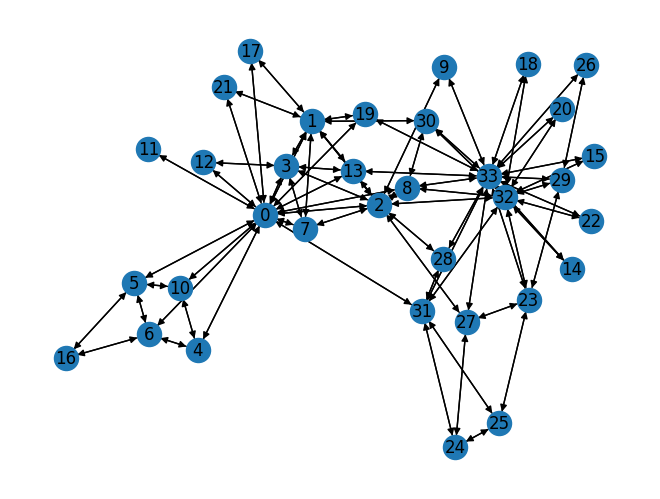

In [2]:
karate_graph= load_karate_graph()
g = nx.DiGraph(karate_graph.edges)
nx.draw(g,with_labels=True)

# Embedding into Hyperbolic space
On the geomstats website, there is an example of how to learn such an embedding using the hyperbolic plane. The way it is done there is to randomly embed the graph into the hyperbolic plane as shown below. 

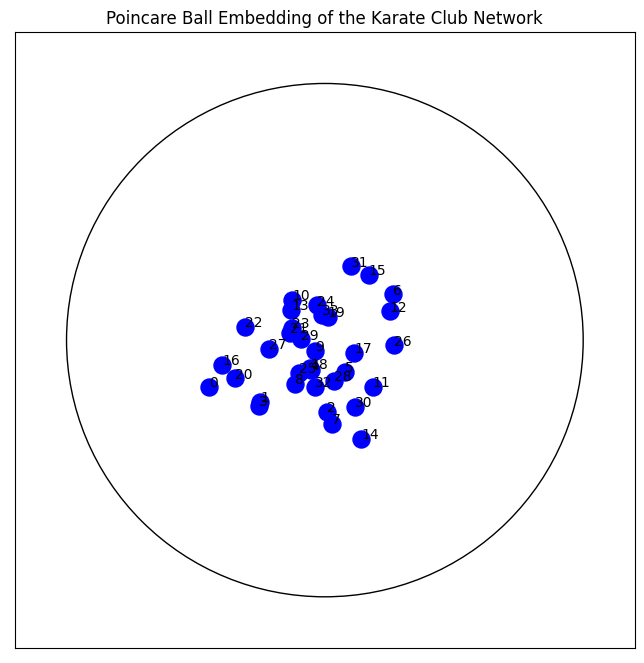

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

embeddings = gs.random.normal(size=(karate_graph.n_nodes, 2))*0.2

circle = visualization.PoincareDisk(coords_type="ball")
fig, ax = plt.subplots(figsize=(8, 8))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
circle.set_ax(ax)
circle.draw(ax=ax)
for i_embedding, embedding in enumerate(embeddings):
    x = embedding[0]
    y = embedding[1]
    pt_id = i_embedding
    plt.scatter(x, y, color='blue', s=150)
    ax.annotate(pt_id, (x, y))

plt.tick_params(which="both")
plt.title("Poincare Ball Embedding of the Karate Club Network")
plt.show()

After this is done, we find the best way to embed the graph in such a way that nodes, which are connected to one another, are placed nearer together in the hyperbolic plane. This step is done using machine learning to minimized a loss function given by the geometry of the manifold. The resulting graph can be seen below.


In [4]:
from geomstats.datasets import prepare_graph_data
Hyperbolic=prepare_graph_data.HyperbolicEmbedding(2)
Embedding_H=Hyperbolic.embed(karate_graph)

INFO: Number of edges: 34
INFO: Mean vertices by edges: 4.588235294117647
INFO: iteration 0 loss_value 1.762951
INFO: iteration 1 loss_value 1.646122
INFO: iteration 2 loss_value 1.591102
INFO: iteration 3 loss_value 1.481306
INFO: iteration 4 loss_value 1.406549
INFO: iteration 5 loss_value 1.390925
INFO: iteration 6 loss_value 1.347527
INFO: iteration 7 loss_value 1.354463
INFO: iteration 8 loss_value 1.334380
INFO: iteration 9 loss_value 1.303649
INFO: iteration 10 loss_value 1.305555
INFO: iteration 11 loss_value 1.290872
INFO: iteration 12 loss_value 1.319154
INFO: iteration 13 loss_value 1.253427
INFO: iteration 14 loss_value 1.300335
INFO: iteration 15 loss_value 1.266679
INFO: iteration 16 loss_value 1.315001
INFO: iteration 17 loss_value 1.271077
INFO: iteration 18 loss_value 1.295802
INFO: iteration 19 loss_value 1.274312
INFO: iteration 20 loss_value 1.241663
INFO: iteration 21 loss_value 1.279973
INFO: iteration 22 loss_value 1.285490
INFO: iteration 23 loss_value 1.258873


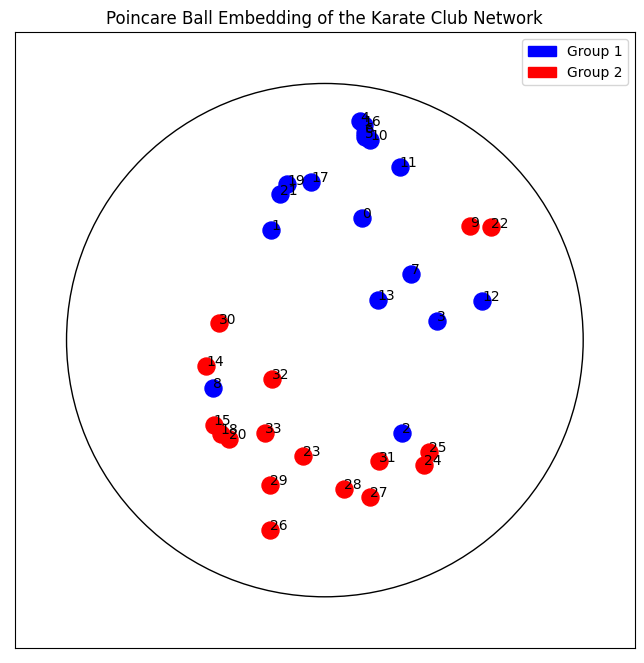

In [10]:
colors = {1: "b", 2: "r"}
group_1 = mpatches.Patch(color=colors[1], label="Group 1")
group_2 = mpatches.Patch(color=colors[2], label="Group 2")

circle = visualization.PoincareDisk(coords_type="ball")

fig, ax = plt.subplots(figsize=(8, 8))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
circle.set_ax(ax)
circle.draw(ax=ax)
for i_embedding, embedding in enumerate(Embedding_H):
    x = embedding[0]
    y = embedding[1]
    pt_id = i_embedding
    plt.scatter(x, y, c=colors[karate_graph.labels[pt_id][0]], s=150)
    ax.annotate(pt_id, (x, y))

plt.tick_params(which="both")
plt.title("Poincare Ball Embedding of the Karate Club Network")
plt.legend(handles=[group_1, group_2])
plt.show()

Here we see that after doing machine learning, the graph is embedded in such a way that the dots are clustered together based on their colors. 

# The Siegel Space 

The Siegel Space of rank two is given by:

$$S_2=\left\{ Y=\begin{pmatrix} z_1 & z_2\\z_2 & z_3\end{pmatrix}, z_i\in \mathbb{C}: I-Y^\dagger Y >>0 \right\}$$



where the condition $Y>>0$ indicates that $Y$ is positive definite (the real number $z^*Yz$ is positive for all nonzero vectors $z\in \mathbb{C}^n$). One can think of it as a complex generalization of the upper half space model of the hyperbolic plane.

In [11]:
from geomstats.geometry import siegel
import numpy as np
siegel_manifold=siegel.Siegel(n=2,symmetric=True)
siegel_metric=siegel.SiegelMetric(2)

In [12]:
def random_point_sym():
    M=siegel_manifold.random_point()
    return 0.5*(np.transpose(M)+M)

In [13]:
import logging
nb_vertices_by_edges = [len(e_2) for _, e_2 in karate_graph.edges.items()]
logging.info("Number of vertices: %s", len(karate_graph.edges))
logging.info(
    "Mean edge-vertex ratio: %s",
    (sum(nb_vertices_by_edges, 0) / len(karate_graph.edges)),
)

INFO: Number of vertices: 34
INFO: Mean edge-vertex ratio: 4.588235294117647


In [14]:
negative_table_parameter = 3
negative_sampling_table = []
c=0
for i, nb_v in enumerate(nb_vertices_by_edges):
    negative_sampling_table += (
        [i] * int((nb_v ** (3.0 / 4.0))) * negative_table_parameter
    )
negative_sampling_table = gs.array(negative_sampling_table)
random_walks = karate_graph.random_walk()

## The Loss Function
The are many loss functions one can use depending on the type of graph embedding problem one is considering, we decided to stick with the loss function given by Thomas Gerald and Hadi Zaatiti as

$$\mathcal{L}=- \sum_{v_i\in V} \sum_{v_j \in C_i} \bigg[ log(\sigma(-d^2(\phi_i, \phi_j'))) + \sum_{v_k\sim \mathcal{P}_n} log(\sigma(d^2(\phi_i, \phi_k')))  \bigg]$$

In [15]:
def grad_squared_distance(point_a, point_b):
    """Gradient of squared hyperbolic distance.

    Gradient of the squared distance based on the
    Ball representation according to point_a

    Parameters
    ----------
    point_a : array-like, shape=[n_samples, dim]
        First point in hyperbolic space.
    point_b : array-like, shape=[n_samples, dim]
        Second point in hyperbolic space.

    Returns
    -------
    dist : array-like, shape=[n_samples, 1]
        Geodesic squared distance between the two points.
    """
    siegel_metric = siegel.SiegelMetric(2)
    log_map = siegel_metric.log(point_b, point_a)

    return -2 * log_map
def log_sigmoid(vector):
    """Logsigmoid function.

    Apply log sigmoid function

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    result : array-like, shape=[n_samples, dim]
    """
    return gs.log((1 / (1 + gs.exp(-vector))))
def grad_log_sigmoid(vector):
    """Gradient of log sigmoid function.

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    gradient : array-like, shape=[n_samples, dim]
    """
    return 1 / (1 + gs.exp(vector))

def loss(example_embedding, context_embedding, negative_embedding, manifold):
    """Compute loss and grad.

    Compute loss and grad given embedding of the current example,
    embedding of the context and negative sampling embedding.
    """
    n_edges, dim = negative_embedding.shape[0], example_embedding.shape[-1]
    example_embedding = gs.expand_dims(example_embedding, 0)
    context_embedding = gs.expand_dims(context_embedding, 0)
    positive_distance = siegel_metric.squared_dist(
        example_embedding, context_embedding
    )
    positive_loss = log_sigmoid(-positive_distance)

    reshaped_example_embedding = gs.repeat(example_embedding, n_edges, axis=0)
    negative_distance = siegel_metric.squared_dist(
        reshaped_example_embedding, negative_embedding
    )
    negative_loss = log_sigmoid(negative_distance)

    total_loss = -(positive_loss + negative_loss.sum())

    positive_log_sigmoid_grad = -grad_log_sigmoid(-positive_distance)

    positive_distance_grad = grad_squared_distance(example_embedding, context_embedding)

    positive_grad = (
        gs.repeat(positive_log_sigmoid_grad, dim, axis=-1) * positive_distance_grad
    )

    negative_distance_grad = grad_squared_distance(
        reshaped_example_embedding, negative_embedding
    )

    negative_distance = gs.to_ndarray(negative_distance, to_ndim=2, axis=-1)
    negative_log_sigmoid_grad = grad_log_sigmoid(negative_distance)

    negative_grad = negative_log_sigmoid_grad * negative_distance_grad
    example_grad = -(positive_grad + negative_grad.sum(axis=0))

    return total_loss, example_grad


## Initialisation
In order to start our embedding, we randomly select 34 points in our Siegel Space.

In [16]:
embeddings = []
for i in range(karate_graph.n_nodes):
    embeddings.append(random_point_sym()*0.1)
embeddings=gs.array(embeddings)

## Riemannian Gradient Descent
In order to optimise our embedding, the algorithm uses Riemannian gradient descent, that is at every node, we update the embedding based on the equation below:
$$ \phi^{t+1} = \text{Exp}_{\phi^t} \left( -lr \frac{\partial L}{\partial \phi} \right) $$
where lr is the learning rate and $\frac{\partial L}{\partial \phi}$ is the gradient of the loss function.

In [17]:
gs.random.seed(1234)
dim = 2
max_epochs = 50
lr = 0.05
n_negative = 2
context_size = 2
siegel_metric = siegel.SiegelMetric(2)


for epoch in range(max_epochs):
    total_loss = []
    for path in random_walks:
        for example_index, one_path in enumerate(path):
            context_index = path[
                max(0, example_index - context_size) : min(
                    example_index + context_size, len(path)
                )
            ]
            negative_index = gs.random.randint(
                negative_sampling_table.shape[0], size=(len(context_index), n_negative)
            )
            negative_index = negative_sampling_table[negative_index]

            example_embedding = embeddings[one_path]
            for one_context_i, one_negative_i in zip(context_index, negative_index):
                context_embedding = embeddings[one_context_i]
                negative_embedding = embeddings[one_negative_i]

                l, g_ex = loss(
                    example_embedding,
                    context_embedding,
                    negative_embedding,
                    siegel_metric,
                )
                total_loss.append(l)
                g_ex=0.5*(g_ex+g_ex.T.reshape(gs.shape(g_ex)))
                
                example_to_update = embeddings[one_path]
                P = siegel_metric.exp(
                    -lr * g_ex, example_to_update
                )
                
                embeddings[one_path]=siegel_manifold.projection(P)
                if siegel_metric.squared_dist(P,gs.array([[0,0],[0,0]]))>9:
                    break

    logging.info(
        "iteration %d loss_value %f", epoch, sum(total_loss, 0) / len(total_loss)
    )
    if sum(total_loss, 0) / len(total_loss)>10:
        break

/Users/ben/opt/anaconda3/envs/ece594n/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in power
  return f_raw(*args, **kwargs)
/Users/ben/opt/anaconda3/envs/ece594n/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
INFO: iteration 0 loss_value 1.997936
INFO: iteration 1 loss_value 1.750415
INFO: iteration 2 loss_value 1.584837
INFO: iteration 3 loss_value 1.518563
INFO: iteration 4 loss_value 1.504505
INFO: iteration 5 loss_value 1.525375
INFO: iteration 6 loss_value 1.538688
INFO: iteration 7 loss_value 1.550467
INFO: iteration 8 loss_value 1.619026
INFO: iteration 9 loss_value 1.655999
INFO: iteration 10 loss_value 1.675390
INFO: iteration 11 loss_value 1.705259
INFO: iteration 12 loss_value 1.774942
INFO: iteration 13 loss_value 1.760092
INFO: iteration 14 loss_value 1.755047
INFO: iteration 15 loss_value 1.842983
INFO: iteration 16 loss_value 1.928842

## Clustering
Now that we have ran the gradient descent, we apply the Riemannian K-means:

In [18]:
from geomstats.learning.kmeans import RiemannianKMeans
n_clusters = 2
kmeans = RiemannianKMeans(
    metric=siegel_metric,
    n_clusters=n_clusters,
    init="random",
    mean_method="default",
)
centroids = kmeans.fit(X=embeddings)
labels = kmeans.predict(X=embeddings)



/Users/ben/opt/anaconda3/envs/ece594n/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in power
  return f_raw(*args, **kwargs)
/Users/ben/opt/anaconda3/envs/ece594n/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


In [19]:
err=[]
for i in range(34):
    err.append([karate_graph.labels[i][0]-1, labels[i]])
print(err)
error=0
for i in range(34):
    if err[i][0]!=err[i][1]:
        error+=1
print('error:',min([error,34-error]))

[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 1], [1, 1], [0, 0], [0, 0], [0, 0], [0, 0], [1, 1], [1, 1], [0, 0], [0, 0], [1, 1], [0, 1], [1, 1], [0, 0], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]
error: 2


## Visualising the embedding
The Siegel Space we are working with has 3 complex dimensions or 6 real dimensions, making it quite difficult to visualise. However, we can apply the PCA to get a sense of how our graph got embedded. Here, we just use the tangent PCA as a way to see the graph.

In [20]:
from geomstats.learning.pca import TangentPCA

tpca = TangentPCA(siegel_metric)

In [21]:
tpca.fit(embeddings)

TangentPCA(metric=<geomstats.geometry.siegel.SiegelMetric object at 0x181268890>)

Text(0, 0.5, 'Fraction of explained variance')

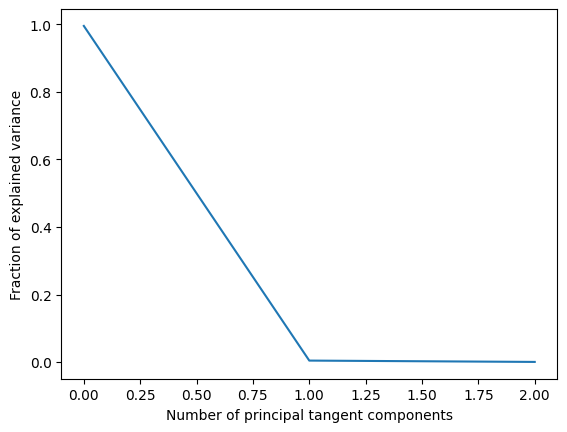

In [23]:
plt.plot(tpca.explained_variance_ratio_)
plt.xlabel("Number of principal tangent components")
plt.ylabel("Fraction of explained variance")

Text(0.5, 0, 'Real values')

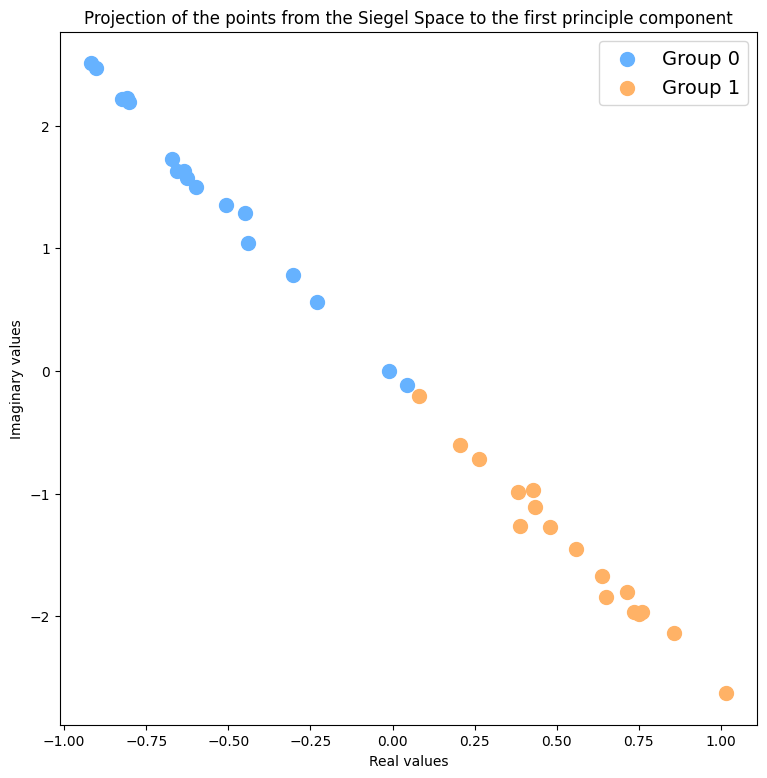

In [28]:
X = tpca.transform(embeddings); plt.figure(figsize=(9, 9))
label_to_color = {
    0: (102 / 255, 178 / 255, 255 / 255, 1.0),
    1: (255 / 255, 178 / 255, 102 / 255, 1.0),
}
for j in [0,1]:
    x=[]
    y=[]
    for i in range(34):
        if karate_graph.labels[i][0]==j+1:
            x.append(gs.real(X[i][0]))
            y.append(gs.imag(X[i][0]))
    plt.scatter(x,y, color=label_to_color[j], s=100, label="Group %d"%j)
plt.legend(fontsize=14)
plt.title("Projection of the points from the Siegel Space to the first principle component")
plt.ylabel("Imaginary values")
plt.xlabel("Real values")

# References
[1] Federico L´opez, Beatrice Pozzetti, Steve Trettel, Michael Strube, and Anna Wienhard. Symmetric spaces for graph embeddings: A finsler-riemannian approach. arXiv preprint arXiv:2106.04941, 2021a.

[2] Lopez, F. and Strube, M. A fully hyperbolic neural ´ model for hierarchical multi-class classification. In Findings of the Association for Computational Linguistics: EMNLP 2020, pp. 460–475, Online, November 2020. Association for Computational Linguistics. URL https://www.aclweb.org/anthology/ 2020.findings-emnlp.42.

[3] Sala, F., De Sa, C., Gu, A., and Re, C. Representation tradeoffs for hyperbolic embeddings. In Dy, J. and Krause, A. (eds.), Proceedings of the 35th International Conference on Machine Learning, volume 80 of Proceedings of Machine Learning Research, pp. 4460– 4469, Stockholmsmassan, Stockholm Sweden, 10–15 ¨ Jul 2018. PMLR. URL http://proceedings.mlr. press/v80/sala18a.html.

Group members: Ricky Lee And Benedict Lee. Both contributed equally to this notebook.